# The second integral of motion

In this example we will reproduce a [famous numerical experiment](https://ui.adsabs.harvard.edu/abs/1964AJ.....69...73H/abstract) investigating the existence of a second integral of motion in axisymmetric potentials. Specifically, we will focus on a two-dimensional dynamical system described by the Hamiltonian

$$
\mathcal{H}\left(\dot{x}, \dot{y}, x, y \right) = \frac{1}{2}\left(\dot{x}^2+\dot{y}^2\right) + U\left(x, y\right),
$$

where

$$
U\left(x, y\right) = \frac{1}{2}\left( x^2 + y^2 + 2x^2y - \frac{2}{3}y^3 \right).
$$

$x$ and $y$ are the cylindrical coordinates ($R$ and $z$) of a point mass moving under the influence of the axially-symmetric potential $U\left(x, y\right)$.

Because we are dealing with an autonomous dynamical system, the Hamiltonian $\mathcal{H}$ is a constant of motion, corresponding to the total energy of the system.
Our objective is to investigate the existence of *another* integral of motion independent of $\mathcal{H}$: if that were the case, we could solve analytically this dynamical system via the [Liouville-Arnold theorem](https://en.wikipedia.org/wiki/Liouville%E2%80%93Arnold_theorem).

## Procedure

Because $\mathcal{H}$ is a constant of motion, we can invert the definition of the Hamiltonian to yield

$$
\frac{1}{2}\dot{x}^2 = \mathcal{H} - U\left(x, y\right) - \frac{1}{2}\dot{y}^2,\tag{1}
$$

which, in turn, implies the constraint

$$
\mathcal{H} - U\left(x, y\right) - \frac{1}{2}\dot{y}^2 \geq 0,\tag{2}
$$

because $\frac{1}{2}\dot{x}^2$ cannot assume negative values. Eq. (2) implicitly defines a *volume* in the $\left(x, y, \dot{y}\right)$ phase space within which the motion of the particle is bounded. On the other hand, *if* another integral of motion $\mathcal{C} = \mathcal{C}\left( \dot{x}, \dot{y}, x, y \right)$ exists, we can invert it to determine
$\dot{x} = \dot{x}\left( x, y, \dot{y}, \mathcal{C} \right)$, plug this definition of $\dot{x}$ into eq. (1) and obtain an equation of type

$$
f\left(x, y, \dot{y}, \mathcal{H}, \mathcal{C}\right) = 0
$$

which defines a *surface* embedded in the phase space $\left(x, y, \dot{y}\right)$, rather than a volume. In other words, the existence of another integral of motion $\mathcal{C}$ further constraints the possible motion of the particle in the $\left(x, y, \dot{y}\right)$ space. Thus, the strategy of our investigation revolves around detecting if the particle motion in phase space is constrained on a surface, rather than within a volume. How can we do that?

A possible answer to this question is to consider the intersections of the particle's trajectory in phase space with a fixed 2D plane (or, in other words, a [Poincare' section](https://en.wikipedia.org/wiki/Poincar%C3%A9_map)). If the particle's trajectory is constrained by a surface (i.e., if the additional integral of motion $\mathcal{C}$ *does* exist), the Poincare' section will consist of a curve representing the intersection of the surface with the 2D plane. If, instead, the particle's trajectory is constrained by a volume (i.e., if the additional integral of motion $\mathcal{C}$ *does not* exist), the Poincare' section will resemble a densely-filled surface, rather than a curve.

## Running the experiments

For the computation of Poincare' sections, we use the plane defined by the condition $x = 0$ (i.e., the $\left(y, \dot{y}\right)$ plane), and, for the sake of consistency with the [original paper](https://ui.adsabs.harvard.edu/abs/1964AJ.....69...73H/abstract), we consider only intersections for which $\dot{x} > 0$ (i.e., the particle is moving from below to above the plane). We will compute different Poincare' sections at different energy levels (i.e., values of the $\mathcal{H}$ constant). The initial value of $x$ is always $0$ (so that the motion always starts on the plane of the Poincare' section), and the initial values for $y$ and $\dot{y}$ are randomly selected. The initial value for $\dot{x}$ is then implicitly defined by the value of the energy constant.

Let us begin by defining a function for the generation of a set of initial conditions from an energy value:

In [1]:
def generate_ic(H):
    import random
    from math import sqrt

    while True:
        # Generate y and vy randomly.
        y = random.uniform(-0.5, 0.5)
        vy = random.uniform(-0.5, 0.5)

        # Compute vx**2 via the inversion of the
        # Hamiltonian, after setting x = 0.
        sq_vx = 2 * H - vy * vy - y * y + 2 / 3.0 * y * y * y

        # Check if vx**2 is positive. Otherwise,
        # we will throw the dice again.
        if sq_vx >= 0:
            # Add a random sign to vx.
            vx = sqrt(sq_vx) if random.randint(0, 1) == 0 else -sqrt(sq_vx)
            break

    return vx, vy, 0.0, y

Next, we define an expression representing the Hamiltonian:

In [2]:
import heyoka as hy

vx, vy, x, y = hy.make_vars("vx", "vy", "x", "y")

Ham = 0.5 * (vx**2 + vy**2) + 0.5 * (x**2 + y**2 + 2 * x**2 * y - 2 / 3.0 * y**3)

In order to detect when the particle crosses the $x=0$ plane, we will be using heyoka.py's [event detection system](<./Event detection.ipynb>). The event equation is simply

$$
x = 0,
$$

whereas for the callback we will be using a function object which will record internally the values of $\dot{y}$ and $y$ when the particle crosses the $x=0$ plane:

In [3]:
# Definition of the event callback.
class ps_callback:
    def __init__(self):
        self.vy_y_list = []

    def __call__(self, ta, t, d_sgn):
        # Compute the state of the system
        # at the event trigger time.
        ta.update_d_output(t)

        # Add the (vy, y) values to the
        # internal list.
        self.vy_y_list.append((ta.d_output[1], ta.d_output[3]))


# Create the event.
ev = hy.nt_event(x, ps_callback(), direction=hy.event_direction.positive)

We can then proceed to the construction of the integrator object:

In [4]:
ta = hy.taylor_adaptive(
    # Hamilton's equations.
    [
        (vx, -hy.diff(Ham, x)),
        (vy, -hy.diff(Ham, y)),
        (x, hy.diff(Ham, vx)),
        (y, hy.diff(Ham, vy)),
    ],
    # Initial conditions (all zeroes for now).
    [0.0] * 4,
    # Event list.
    nt_events=[ev],
)

We can now proceed to numerically compute and plot the Poincare' sections. We define a small helper function that, given an input energy level, generates and integrate a few random orbits. The event object will record internally the intersections of these orbits with the $x=0$ plane, which will then be used to plot the Poincare' section:

In [5]:
def plot_poincare(H):
    from matplotlib.pylab import plt
    import numpy as np

    fig = plt.figure(figsize=(12, 9))

    for i in range(20):
        # Reset the integrator time.
        ta.time = 0
        # Generate random initial conditions.
        ta.state[:] = generate_ic(H)
        # Reset the list of intersection points
        # in the event object.
        ta.nt_events[0].callback.vy_y_list = []

        # Integrate for a few time units.
        ta.propagate_until(2000.0)

        # Extract the intersection points as
        # a 2D numpy array.
        pts = np.array(ta.nt_events[0].callback.vy_y_list)

        # Plot the intersection points.
        # NOTE: each set of initial conditions will
        # be plotted with a different color.
        plt.scatter(pts[:, 1], pts[:, 0], s=2.5)

    plt.xlabel(r"$y$")
    plt.ylabel(r"$\dot{y}$")

As done in the [original paper](https://ui.adsabs.harvard.edu/abs/1964AJ.....69...73H/abstract), let us first plot a Poincare' section for the energy level $\mathcal{H} = 0.083333$:

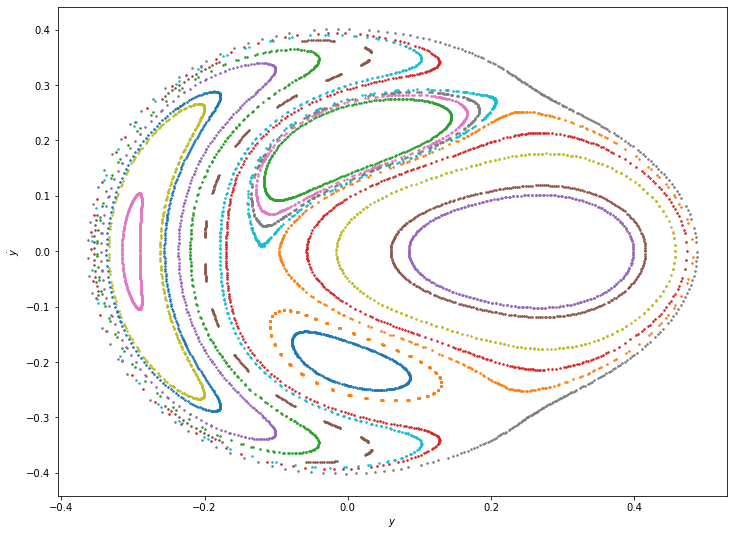

In [6]:
plot_poincare(0.083333)

This Poincare' section is suggesting that the integral of motion $\mathcal{C}$ does indeed exist, because the intersections of all random orbits are clearly tracing curves on the $x=0$ plane.

> **NOTE**: if you are running this tutorial in interactive mode, feel free to re-execute the previous cell to randomly generate a new Poincare' section with the same energy level.

But what happens if we try to compute the Poincare' section for another energy level?

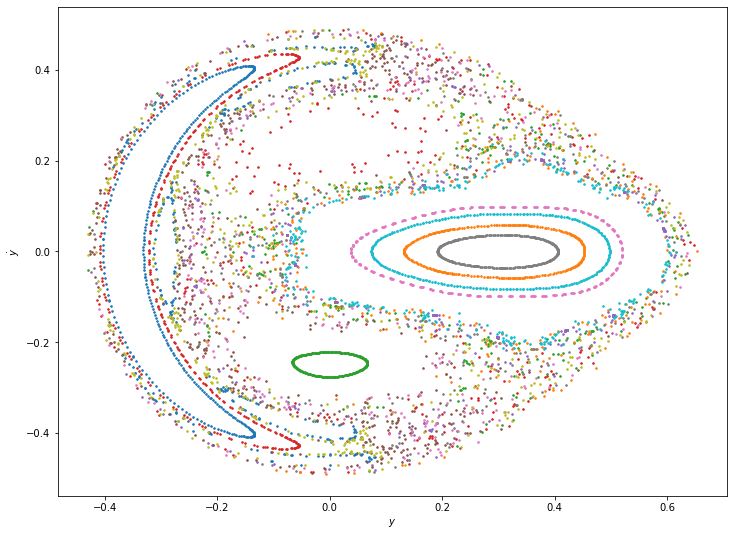

In [7]:
plot_poincare(0.125)

The qualitative picture is now radically different. Although islands of stable motion persist, now most trajectories seem to be densely filling the plane, rather than tracing curves on it. Let us further increase the energy level:

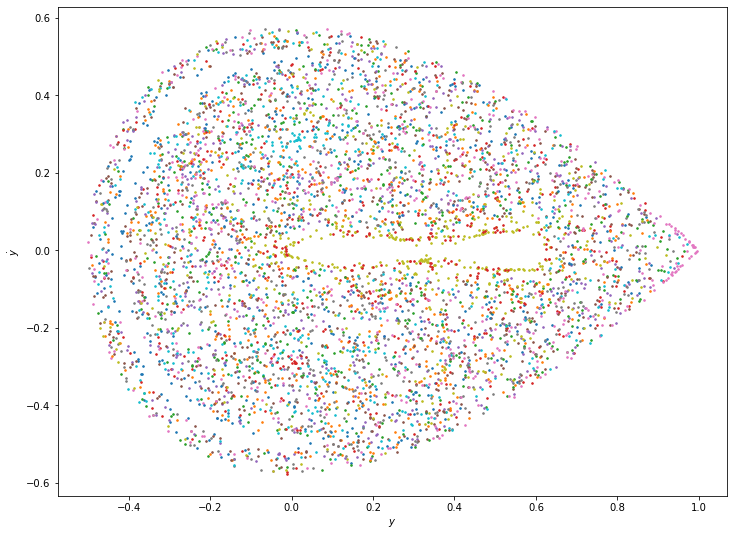

In [8]:
plot_poincare(0.16667)

At higher energies, the densely-filling behaviour (which Henon and Heiles call *ergodic*) is even more prevalent than before.

## Conclusions

These numerical experiments indicate that, in general, no additional integrals of motion (beside the energy) exist for axisymmetric potentials. Note that this result does not imply that no additional integrals exist for *some* axisymmetric potentials (e.g., see [Euler's three body problem](https://en.wikipedia.org/wiki/Euler%27s_three-body_problem), which is solvable via elliptic functions), but that just an additional integral of motion cannot be defined generically for *all* axisymmetric potentials.